# Introduction

How much does what is included in the annotation set matter?

In [119]:
import seaborn
import scipy
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot
import sys
import pysam
from collections import Counter

import upsetplot

In [2]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR724KET_16f_nuc'

In [3]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [4]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "SJ"]

    analysis_dir = Path(analysis_dir)
    feature_name = "features.tsv"
    
    solo_dir = analysis_dir / "Solo.out" / quantification / mode
    solo = scanpy.read_mtx(solo_dir / "matrix.mtx").T
    solo_vars = pandas.read_csv(
        solo_dir / feature_name, header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



In [5]:
tenx_root = Path("starsolo_2.7.9a_2021-06-25_encode-forward+cr")
tenx_genefull = scanpy_load_solo278a_mtx(tenx_root, "GeneFull", "filtered")
tenx_genefull.var_names.to_list()[:5]

['ENSG00000243485',
 'ENSG00000237613',
 'ENSG00000186092',
 'ENSG00000238009',
 'ENSG00000239945']

In [6]:
encode_root = Path("fullsolo_2.7.9a_2021-06-25")
encode_genefull = scanpy_load_solo278a_mtx(encode_root, "GeneFull", "filtered")
encode_genefull.var_names.to_list()[:5]

['ENSG00000223972.5',
 'ENSG00000227232.5',
 'ENSG00000278267.1',
 'ENSG00000243485.5',
 'ENSG00000284332.1']

In [7]:
minimal_root = Path("minimalsolo_2.7.9a_2021-06-25")
minimal_genefull = scanpy_load_solo278a_mtx(minimal_root, "GeneFull", "filtered")
minimal_genefull.var_names.to_list()[:5]

['ENSG00000243485.5',
 'ENSG00000237613.2',
 'ENSG00000186092.6',
 'ENSG00000238009.6',
 'ENSG00000239945.1']

In [8]:
print("tenx", tenx_genefull.shape, tenx_genefull.X.sum())
print("encode", encode_genefull.shape, encode_genefull.X.sum())
print("minimal", minimal_genefull.shape, minimal_genefull.X.sum())

tenx (15812, 36601) 84269840.0
encode (15605, 59526) 80314560.0
minimal (15650, 28249) 78668630.0


In [9]:
tenx_genefull.var_names.to_list()[:5]

['ENSG00000243485',
 'ENSG00000237613',
 'ENSG00000186092',
 'ENSG00000238009',
 'ENSG00000239945']

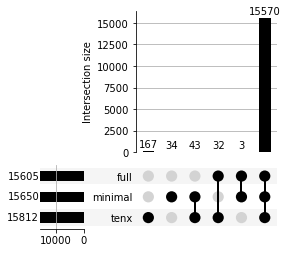

In [10]:
common_barcode_set = upsetplot.from_contents({
    'tenx': tenx_genefull.obs_names,
    'full': encode_genefull.obs_names,
    'minimal': minimal_genefull.obs_names,
})
_ = upsetplot.plot(common_barcode_set, show_counts=True)

In [11]:
barcode_intersection = set(encode_genefull.obs_names).intersection(minimal_genefull.obs_names).intersection(tenx_genefull.obs_names)
common_barcodes = [ x for x in encode_genefull.obs_names if x in barcode_intersection]

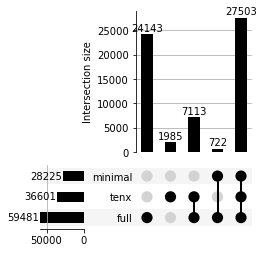

In [12]:
tenx_base_ids = set(tenx_genefull.var_names)
full_base_ids = set()
for x in encode_genefull.var_names:
    full_base_ids.add(x.split('.')[0])

minimal_base_ids = set()
for x in minimal_genefull.var_names:
    minimal_base_ids.add(x.split('.')[0])

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
common_gene_base_set = upsetplot.from_contents({
    'tenx': tenx_base_ids,
    'full': full_base_ids,
    'minimal': minimal_base_ids,
})
_ = upsetplot.plot(common_gene_base_set, show_counts=True)

In [13]:
common_gene_base_set.loc[True,True,False]

<ipython-input-13-4f14f68b2b9d>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  common_gene_base_set.loc[True,True,False]


id
tenx full minimal                 
True True False    ENSG00000263051
          False    ENSG00000265688
          False    ENSG00000285347
          False    ENSG00000262703
          False    ENSG00000267244
...                            ...
          False    ENSG00000285184
          False    ENSG00000260886
          False    ENSG00000285604
          False    ENSG00000272145
          False    ENSG00000233340

[7113 rows x 1 columns]

In [14]:
v29_common_gene_ids = set(encode_genefull.var_names).intersection(minimal_genefull.var_names)
common_genes = [x for x in encode_genefull.var_names if x.split('.')[0] in tenx_base_ids and x in v29_common_gene_ids]
print(len(common_genes))
common_genes[:5]

27527


['ENSG00000243485.5',
 'ENSG00000237613.2',
 'ENSG00000186092.6',
 'ENSG00000238009.6',
 'ENSG00000239945.1']

In [15]:
common_gene_base = [x.split('.')[0] for x in encode_genefull.var_names if x.split('.')[0] in tenx_base_ids and x in v29_common_gene_ids]
common_gene_base_extended = [x for x in encode_genefull.var_names if x.split('.')[0] in tenx_base_ids and x in v29_common_gene_ids]
print(len(common_gene_base))
common_gene_base[:5]

27527


['ENSG00000243485',
 'ENSG00000237613',
 'ENSG00000186092',
 'ENSG00000238009',
 'ENSG00000239945']

In [16]:
encode_common = encode_genefull[common_barcodes, common_genes]
encode_common.shape, encode_common.X.sum()

((15570, 27527), 75876300.0)

In [17]:
minimal_common = minimal_genefull[common_barcodes, common_genes]
minimal_common.shape, minimal_common.X.sum()

((15570, 27527), 78301460.0)

In [18]:
tenx_common = tenx_genefull[common_barcodes, common_gene_base]
tenx_common.shape, tenx_common.X.sum()

((15570, 27527), 80402320.0)

In [19]:
numpy.any(encode_common.var_names.duplicated())

False

In [20]:
len(tenx_common.var_names), len(common_gene_base_extended)

(27527, 27527)

In [21]:
tenx_common.var_names = common_gene_base_extended

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [22]:
filtered_cors = compute_spearman_anndata(tenx_common, encode_common)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [23]:
filtered_cors

AAACAGCCAAATGCCC    1.000000
AAACAGCCACGTGCTG         NaN
AAACAGCCACTTAGGC         NaN
AAACAGCCAGGGAGCT    0.436187
AAACAGCCATGTTTGG         NaN
                      ...   
TTTGTTGGTGAGCAAG    1.000000
TTTGTTGGTGCTCACC    0.999776
TTTGTTGGTGCTTACT    1.000000
TTTGTTGGTGCTTAGA    1.000000
TTTGTTGGTTACATCC         NaN
Length: 15570, dtype: float64

In [24]:
filtered_cors.dropna()

AAACAGCCAAATGCCC    1.000000
AAACAGCCAGGGAGCT    0.436187
AAACATGCAAACGGGC    1.000000
AAACATGCAATTGAGA    0.912783
AAACATGCAGGAAGCC    0.839989
                      ...   
TTTGTTGGTCCTAAGA    1.000000
TTTGTTGGTGAGCAAG    1.000000
TTTGTTGGTGCTCACC    0.999776
TTTGTTGGTGCTTACT    1.000000
TTTGTTGGTGCTTAGA    1.000000
Length: 13381, dtype: float64

In [25]:
encode_common

View of AnnData object with n_obs × n_vars = 15570 × 27527
    obs: 'counts', 'ngenes'

In [26]:
encode_common_sum = pandas.Series(numpy.asarray(encode_common.X.sum(axis=1)).T[0])


In [27]:
encode_idxmax = encode_common_sum.idxmax()
encode_max_cell = encode_common.obs_names[encode_idxmax]
encode_max_cell

'GCATCCTTCTAAGTGC'

In [28]:
efg = encode_common[encode_max_cell].to_df().T
efg.describe()

,GCATCCTTCTAAGTGC
count,27527.000000
mean,4.686889
std,82.876060
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,13548.000000


In [29]:
tfg = tenx_common[encode_max_cell].to_df().T
tfg.describe()

,GCATCCTTCTAAGTGC
count,27527.000000
mean,4.934937
std,83.247360
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,13597.000000


In [30]:
mfg = minimal_common[encode_max_cell].to_df().T
mfg.describe()

,GCATCCTTCTAAGTGC
count,27527.000000
mean,4.825989
std,83.329659
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,13611.000000


In [31]:
assert numpy.all(efg.index == tfg.index), "feature lists are not in same order "

In [32]:
expressed = (efg > 0) | (tfg > 0)

In [33]:
rad = (numpy.abs(efg - tfg) / numpy.maximum(efg, tfg))

<AxesSubplot:ylabel='Frequency'>

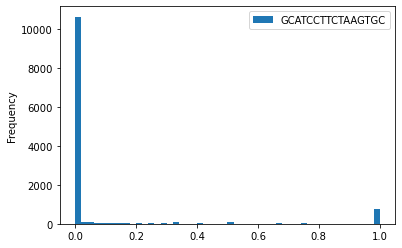

In [34]:
rad.plot.hist(bins=50)

# Compare highest expressed cell between full and minimal annotations

<ipython-input-35-769fef1cb76a>:5: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined_gene).plot.scatter(x="{}_full".format(encode_max_cell), y="{}_minimal".format(encode_max_cell), ax=ax)


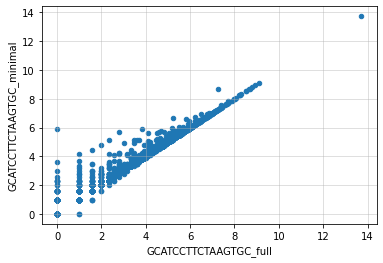

In [35]:
combined_gene = pandas.merge(efg, mfg, left_index=True, right_index=True, suffixes=("_full", "_minimal"))
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

p = numpy.log2(combined_gene).plot.scatter(x="{}_full".format(encode_max_cell), y="{}_minimal".format(encode_max_cell), ax=ax)

ax.grid(alpha=.5)

# Compare highest expressed cell between full and tenx annotations

<ipython-input-36-8cec4bdc9dee>:5: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(tenx_combined_gene).plot.scatter(x="{}_full".format(encode_max_cell), y="{}_tenx".format(encode_max_cell), ax=ax)


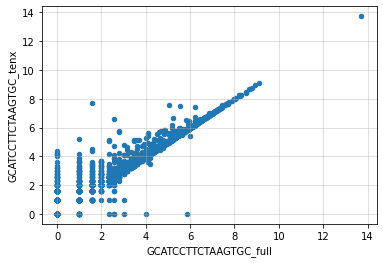

In [36]:
tenx_combined_gene = pandas.merge(efg, tfg, left_index=True, right_index=True, suffixes=("_full", "_tenx"))
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

p = numpy.log2(tenx_combined_gene).plot.scatter(x="{}_full".format(encode_max_cell), y="{}_tenx".format(encode_max_cell), ax=ax)
ax.grid(alpha=.5)

<ipython-input-37-73f046b6bab6>:5: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(minimal_combined_gene).plot.scatter(x="{}_minimal".format(encode_max_cell), y="{}_tenx".format(encode_max_cell), ax=ax)


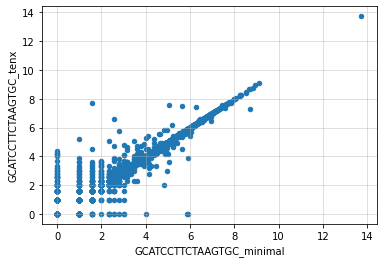

In [37]:
minimal_combined_gene = pandas.merge(mfg, tfg, left_index=True, right_index=True, suffixes=("_minimal", "_tenx"))
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

p = numpy.log2(minimal_combined_gene).plot.scatter(x="{}_minimal".format(encode_max_cell), y="{}_tenx".format(encode_max_cell), ax=ax)
ax.grid(alpha=.5)

In [38]:
encode_genefull_cors = compute_spearman_anndata(encode_common, minimal_common)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


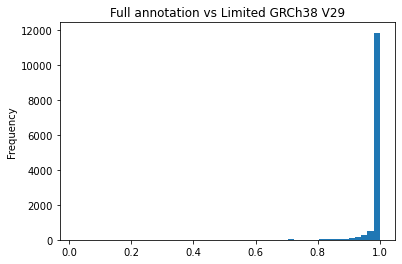

In [39]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title("Full annotation vs Limited GRCh38 V29")
_ = encode_genefull_cors.plot.hist(bins=50, ax=ax)


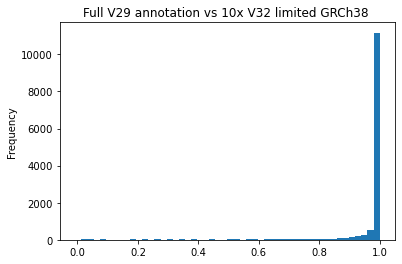

In [40]:
tenx_genefull_cors = compute_spearman_anndata(encode_common, tenx_common)
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title("Full V29 annotation vs 10x V32 limited GRCh38 ")
_ = tenx_genefull_cors.plot.hist(bins=50)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


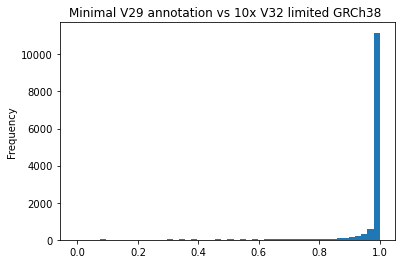

In [41]:
restricted_cors = compute_spearman_anndata(minimal_common, tenx_common)
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title("Minimal V29 annotation vs 10x V32 limited GRCh38 ")
_ = restricted_cors.plot.hist(bins=50)

# Plot GeneFull correlations

Well that's an improvement. Looks like they're counting introns.

In [42]:
tenx_genefull_cors[(tenx_genefull_cors > 0.8) & (tenx_genefull_cors < 0.81)]

ACACGGACACTCAACA    0.801655
AGCAATTGTTCCTCCT    0.803016
ATTTAGGTCCCGCAAA    0.800029
CCACATTGTTCCTCCT    0.801837
CGTTAGTAGTCACCTC    0.801655
CTGCTATGTTGCGGAT    0.801332
GATCAGGCAACTAGCC    0.801297
GCAATAGAGCTGTAAC    0.804382
GCAGGATAGCACCACA    0.807016
GCCAACATCAAGTGAG    0.807015
GCCAGGAAGCGCTCAA    0.804825
GGATTGCGTTTCCTCC    0.806650
GGCTATTAGCATGACT    0.800453
GGGTTATTCTCCATGC    0.801734
GGTTATATCTGTGAGT    0.800867
GTAATAGCAGCAATAA    0.803598
TAACCAGGTGTTGTGA    0.806044
TCAAGAACACGAATCC    0.802478
TGATTCAAGCTACTGG    0.807053
TGTTAGCAGGAAACTG    0.808924
dtype: float64

In [43]:
cell_id = tenx_genefull_cors[(tenx_genefull_cors > 0.8) & (tenx_genefull_cors < 0.81)].index[0]
cell_id

'ACACGGACACTCAACA'

In [44]:
def plot_cell(left, left_suffix, right, right_suffix, cell):
    left_cell = left[cell].to_df().T
    right_cell = right[cell].to_df().T
    combined = pandas.merge(
        left_cell, right_cell, left_index=True, right_index=True, 
        suffixes=("_{}".format(left_suffix), "_{}".format(right_suffix)))
    f = pyplot.figure()
    ax = f.add_subplot(1,1,1)

    p = numpy.log2(combined).plot.scatter(
        x="{}_{}".format(cell, left_suffix), 
        y="{}_{}".format(cell, right_suffix), ax=ax)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xlim(0,1e5)
    #ax.set_ylim(0,1e5)
    ax.grid(alpha=.5)

<ipython-input-44-b996a9ba379e>:10: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined).plot.scatter(


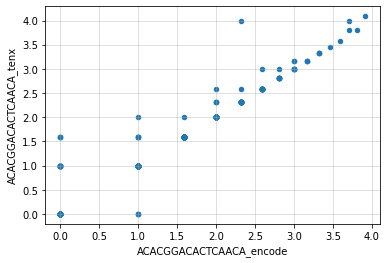

In [45]:
plot_cell(encode_common, 'encode', tenx_common, 'tenx', cell_id)

# Lets try the scanpy tutorial

In [46]:
genome_dir = Path("~/proj/genome/").expanduser()
store = pandas.HDFStore(genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5")
gtf = store['/gtf']
store.close()
gene_id_to_name = gtf[gtf['type'] == 'gene'][["gene_id", "gene_name"]].set_index("gene_id").to_dict()['gene_name']

In [47]:
encode_genefull.var['gene_name'] = [gene_id_to_name.get(x, x) for x in encode_genefull.var_names]

In [48]:
encode_genefull

AnnData object with n_obs × n_vars = 15605 × 59526
    obs: 'counts', 'ngenes'
    var: 'gene_name'

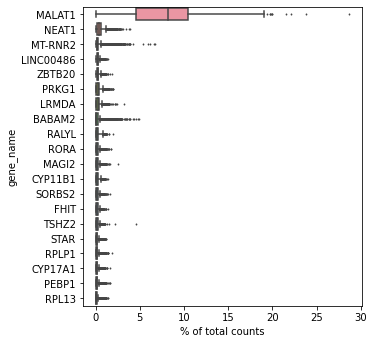

In [49]:
scanpy.pl.highest_expr_genes(encode_genefull, n_top=20, gene_symbols='gene_name')

In [50]:
scanpy.pp.filter_cells(encode_genefull, min_genes=200)
scanpy.pp.filter_genes(encode_genefull, min_cells=3)
encode_genefull

AnnData object with n_obs × n_vars = 15605 × 32644
    obs: 'counts', 'ngenes', 'n_genes'
    var: 'gene_name', 'n_cells'

In [51]:
encode_genefull.var['mt'] = encode_genefull.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_genefull, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'gene_name' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: Us

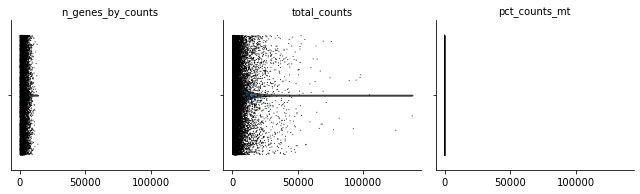

In [52]:
scanpy.pl.violin(encode_genefull, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

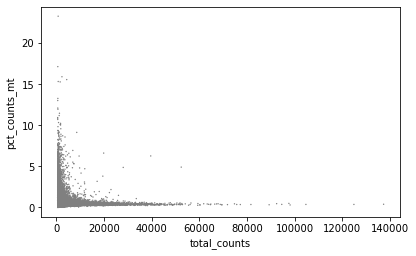

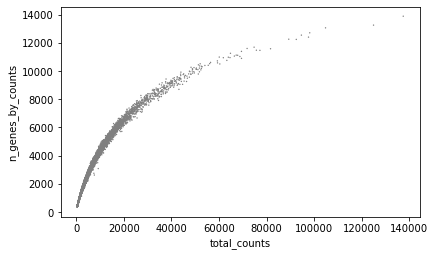

In [53]:
scanpy.pl.scatter(encode_genefull, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(encode_genefull, x='total_counts', y='n_genes_by_counts')



In [54]:
encode_genefull_filtered = encode_genefull[encode_genefull.obs.n_genes_by_counts < 2000, :]
encode_genefull_filtered = encode_genefull_filtered[encode_genefull_filtered.obs.pct_counts_mt < 2.5, :]
encode_genefull_filtered

View of AnnData object with n_obs × n_vars = 8154 × 32644
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


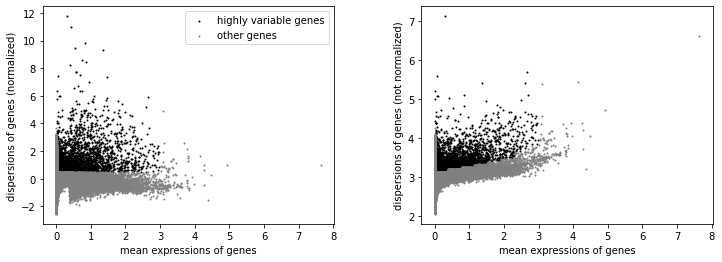

View of AnnData object with n_obs × n_vars = 8154 × 6391
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [55]:
scanpy.pp.normalize_total(encode_genefull_filtered, target_sum=30000)
scanpy.pp.log1p(encode_genefull_filtered)
scanpy.pp.highly_variable_genes(encode_genefull_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(encode_genefull_filtered)
encode_genefull_filtered.raw = encode_genefull_filtered
encode_genefull_filtered = encode_genefull_filtered[:, encode_genefull_filtered.var.highly_variable]
encode_genefull_filtered

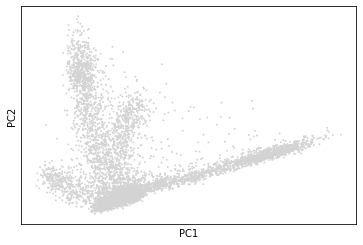

In [56]:
scanpy.pp.regress_out(encode_genefull_filtered, ['total_counts', 'pct_counts_mt'])
scanpy.pp.scale(encode_genefull_filtered, max_value=10)
scanpy.tl.pca(encode_genefull_filtered, svd_solver='arpack')
scanpy.pl.pca(encode_genefull_filtered)

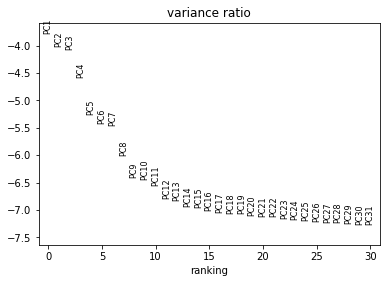

In [57]:
scanpy.pl.pca_variance_ratio(encode_genefull_filtered, log=True)

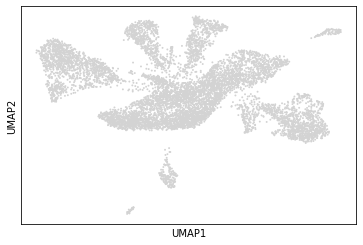

In [58]:
scanpy.pp.neighbors(encode_genefull_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(encode_genefull_filtered)
scanpy.pl.umap(encode_genefull_filtered)

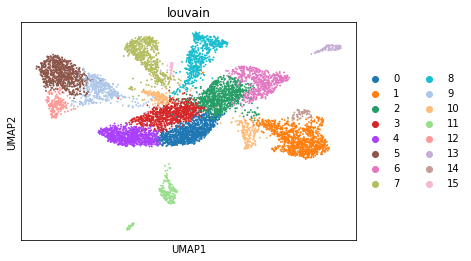

In [59]:
scanpy.tl.louvain(encode_genefull_filtered)
scanpy.pl.umap(encode_genefull_filtered, color=['louvain'])

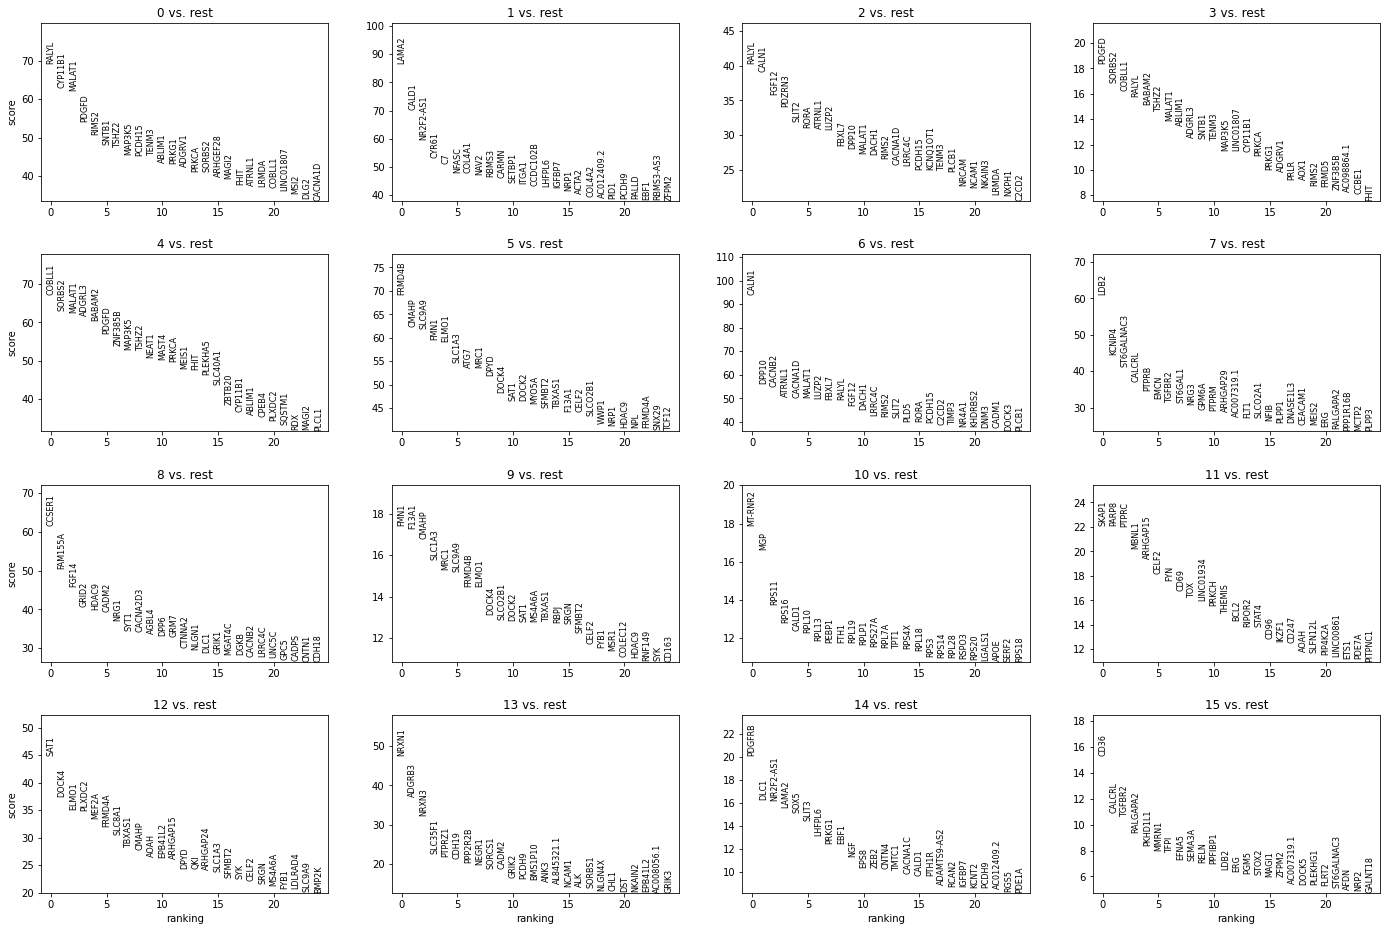

In [60]:
scanpy.tl.rank_genes_groups(encode_genefull_filtered, 'louvain', method='t-test')
scanpy.pl.rank_genes_groups(encode_genefull_filtered, n_genes=25, sharey=False, gene_symbols='gene_name')

In [61]:
encode_genefull_filtered_top_gene_ids = pandas.DataFrame(encode_genefull_filtered.uns['rank_genes_groups']['names'])
encode_genefull_filtered_top_gene_names = encode_genefull_filtered_top_gene_ids.applymap(lambda x: gene_id_to_name.get(x, x))
encode_genefull_filtered_top_gene_names.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,RALYL,LAMA2,RALYL,PDGFD,COBLL1,FRMD4B,CALN1,LDB2,CCSER1,FMN1,MT-RNR2,SKAP1,SAT1,NRXN1,PDGFRB,CD36
1,CYP11B1,CALD1,CALN1,SORBS2,SORBS2,CMAHP,DPP10,KCNIP4,FAM155A,F13A1,MGP,PARP8,DOCK4,ADGRB3,DLC1,CALCRL
2,MALAT1,NR2F2-AS1,FGF12,COBLL1,MALAT1,SLC9A9,CACNB2,ST6GALNAC3,FGF14,CMAHP,RPS11,PTPRC,ELMO1,NRXN3,NR2F2-AS1,TGFBR2
3,PDGFD,CYR61,PDZRN3,RALYL,ADGRL3,FMN1,ATRNL1,CALCRL,GRID2,SLC1A3,RPS16,MBNL1,PLXDC2,SLC35F1,LAMA2,RALGAPA2
4,RIMS2,C7,SLIT2,BABAM2,BABAM2,ELMO1,CACNA1D,PTPRB,HDAC9,MRC1,CALD1,ARHGAP15,MEF2A,PTPRZ1,SOX5,PKHD1L1


# Use our minimal V29 annotation

In [62]:
minimal_genefull.var['gene_name'] = [gene_id_to_name.get(x, x) for x in minimal_genefull.var_names]
minimal_genefull

AnnData object with n_obs × n_vars = 15650 × 28249
    obs: 'counts', 'ngenes'
    var: 'gene_name'

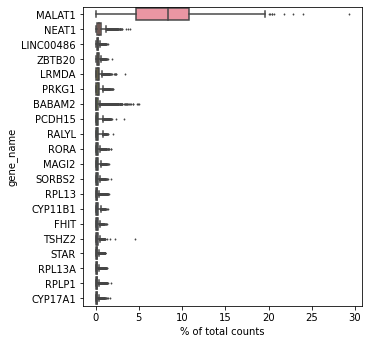

In [63]:
scanpy.pl.highest_expr_genes(minimal_genefull, n_top=20, gene_symbols="gene_name")

In [64]:
scanpy.pp.filter_cells(minimal_genefull, min_genes=200)
scanpy.pp.filter_genes(minimal_genefull, min_cells=3)
tenx_genefull

AnnData object with n_obs × n_vars = 15812 × 36601
    obs: 'counts', 'ngenes'

In [65]:
minimal_genefull.var['mt'] = minimal_genefull.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(minimal_genefull, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'gene_name' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: Us

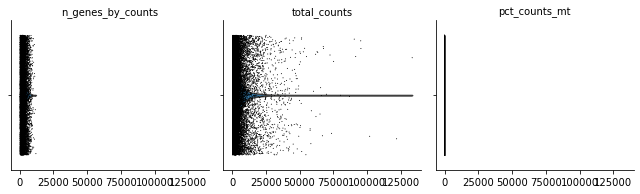

In [66]:
scanpy.pl.violin(minimal_genefull, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

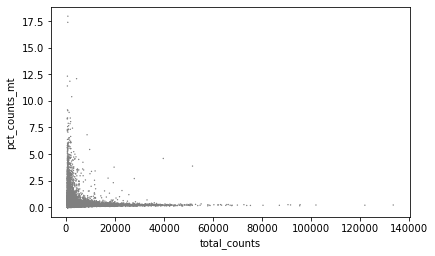

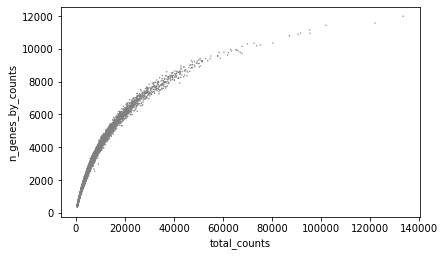

In [67]:
scanpy.pl.scatter(minimal_genefull, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(minimal_genefull, x='total_counts', y='n_genes_by_counts')

In [68]:
minimal_genefull_filtered = minimal_genefull[minimal_genefull.obs.n_genes_by_counts < 2000, :]
minimal_genefull_filtered = minimal_genefull_filtered[minimal_genefull_filtered.obs.pct_counts_mt < 2.5, :]
minimal_genefull_filtered

View of AnnData object with n_obs × n_vars = 9114 × 22540
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


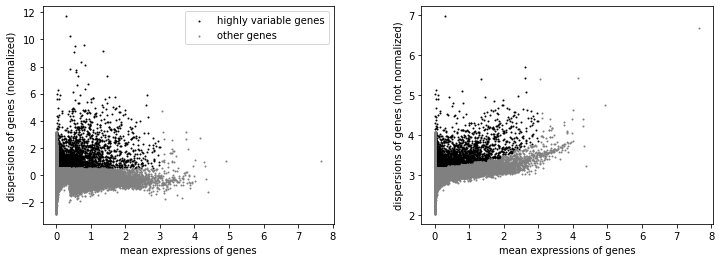

View of AnnData object with n_obs × n_vars = 9114 × 4351
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [69]:
scanpy.pp.normalize_total(minimal_genefull_filtered, target_sum=30000)
scanpy.pp.log1p(minimal_genefull_filtered)
scanpy.pp.highly_variable_genes(minimal_genefull_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(minimal_genefull_filtered)

minimal_genefull_filtered.raw = minimal_genefull_filtered
minimal_genefull_filtered = minimal_genefull_filtered[:, minimal_genefull_filtered.var.highly_variable]
minimal_genefull_filtered

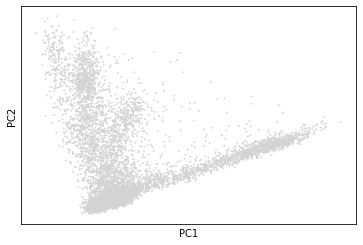

In [70]:
scanpy.pp.regress_out(minimal_genefull_filtered, ['total_counts', 'pct_counts_mt'])
scanpy.pp.scale(minimal_genefull_filtered, max_value=10)
scanpy.tl.pca(minimal_genefull_filtered, svd_solver='arpack')
scanpy.pl.pca(minimal_genefull_filtered)

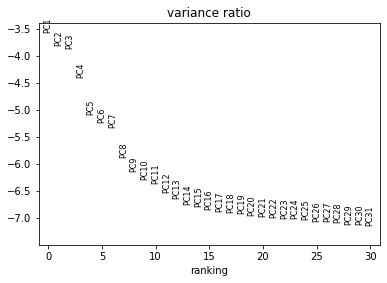

In [71]:
scanpy.pl.pca_variance_ratio(minimal_genefull_filtered, log=True)

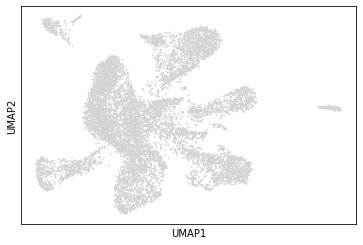

In [72]:
scanpy.pp.neighbors(minimal_genefull_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(minimal_genefull_filtered)
scanpy.pl.umap(minimal_genefull_filtered)

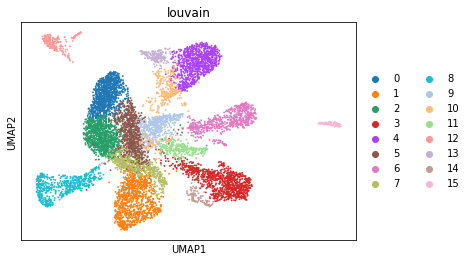

In [73]:
scanpy.tl.louvain(minimal_genefull_filtered)
scanpy.pl.umap(minimal_genefull_filtered, color=['louvain'])

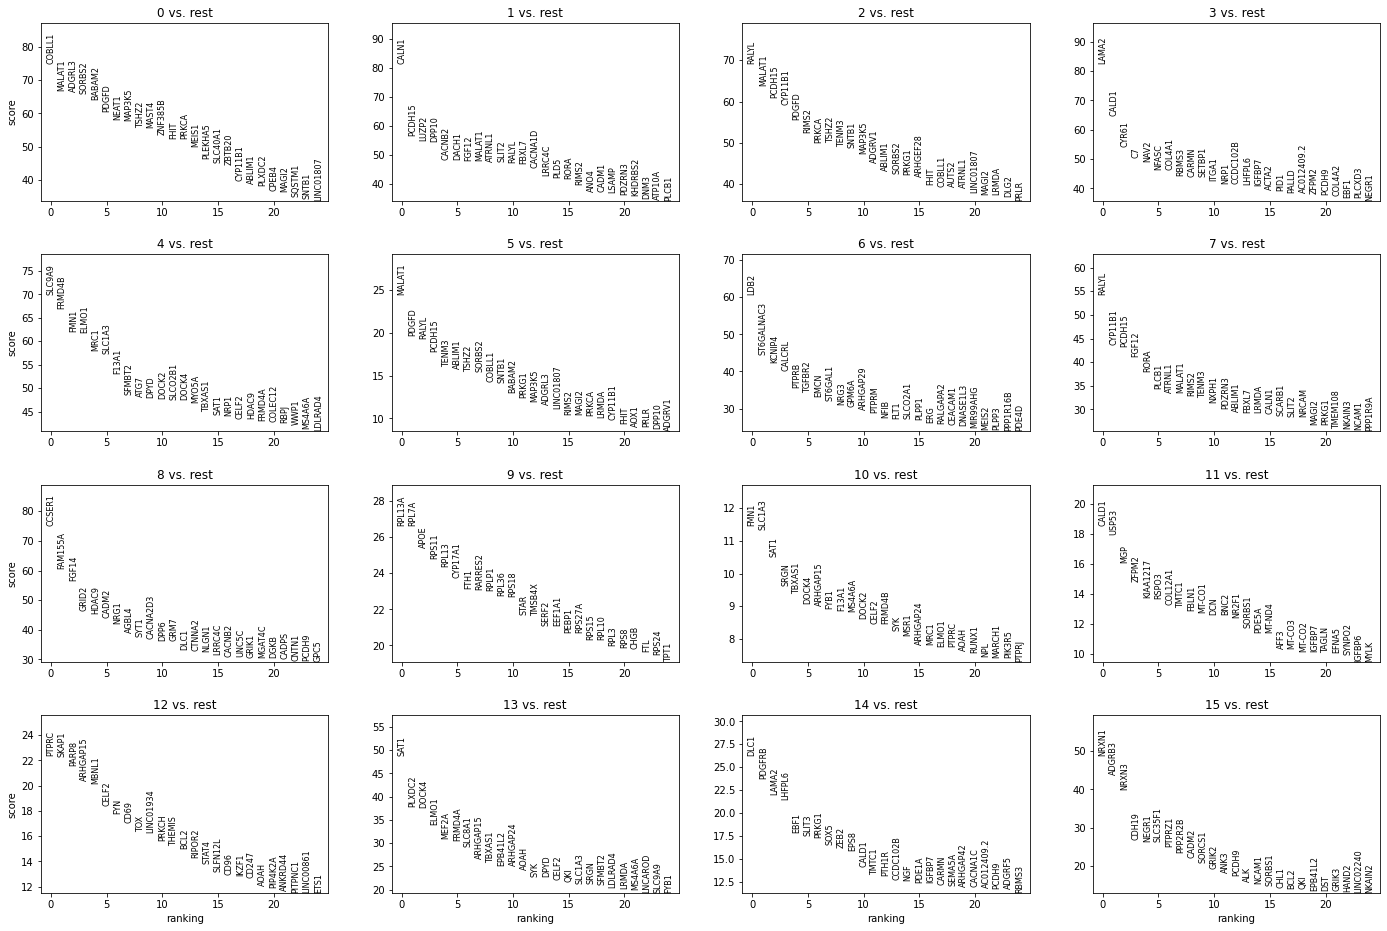

In [74]:
scanpy.tl.rank_genes_groups(minimal_genefull_filtered, 'louvain', method='t-test')
scanpy.pl.rank_genes_groups(minimal_genefull_filtered, n_genes=25, sharey=False, gene_symbols='gene_name')

In [75]:
minimal_genefull_filtered_top_gene_ids = pandas.DataFrame(minimal_genefull_filtered.uns['rank_genes_groups']['names'])
minimal_genefull_filtered_top_gene_names = minimal_genefull_filtered_top_gene_ids.applymap(lambda x: gene_id_to_name.get(x, x))
minimal_genefull_filtered_top_gene_names.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,COBLL1,CALN1,RALYL,LAMA2,SLC9A9,MALAT1,LDB2,RALYL,CCSER1,RPL13A,FMN1,CALD1,PTPRC,SAT1,DLC1,NRXN1
1,MALAT1,PCDH15,MALAT1,CALD1,FRMD4B,PDGFD,ST6GALNAC3,CYP11B1,FAM155A,RPL7A,SLC1A3,USP53,SKAP1,PLXDC2,PDGFRB,ADGRB3
2,ADGRL3,LUZP2,PCDH15,CYR61,FMN1,RALYL,KCNIP4,PCDH15,FGF14,APOE,SAT1,MGP,PARP8,DOCK4,LAMA2,NRXN3
3,SORBS2,DPP10,CYP11B1,C7,ELMO1,PCDH15,CALCRL,FGF12,GRID2,RPS11,SRGN,ZFPM2,ARHGAP15,ELMO1,LHFPL6,CDH19
4,BABAM2,CACNB2,PDGFD,NAV2,MRC1,TENM3,PTPRB,RORA,HDAC9,RPL13,TBXAS1,KIAA1217,MBNL1,MEF2A,EBF1,NEGR1


# using 10x annotations

In [76]:
genome_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/").expanduser()
store = pandas.HDFStore(genome_dir / "GRCh38-arc2.0-2.7.8a" / "GRCh38-arc2.0-2.7.8a.h5")
gtf_base = store['/gtf']
store.close()
gene_base_to_name = gtf_base[gtf_base['type'] == 'gene'][["gene_id", "gene_name"]].set_index("gene_id").to_dict()['gene_name']

In [77]:
tenx_genefull.var['gene_name'] = [gene_base_to_name.get(x, x) for x in tenx_genefull.var_names]
tenx_genefull

AnnData object with n_obs × n_vars = 15812 × 36601
    obs: 'counts', 'ngenes'
    var: 'gene_name'

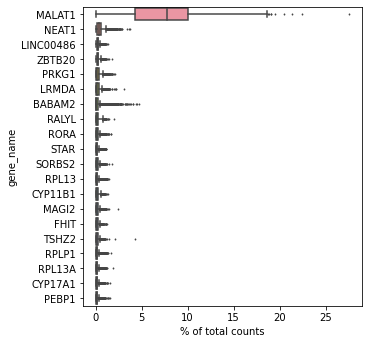

In [78]:
scanpy.pl.highest_expr_genes(tenx_genefull, n_top=20, gene_symbols="gene_name")

In [79]:
scanpy.pp.filter_cells(tenx_genefull, min_genes=200)
scanpy.pp.filter_genes(tenx_genefull, min_cells=3)
tenx_genefull

AnnData object with n_obs × n_vars = 15812 × 29057
    obs: 'counts', 'ngenes', 'n_genes'
    var: 'gene_name', 'n_cells'

In [80]:
tenx_genefull.var['mt'] = tenx_genefull.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(tenx_genefull, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored

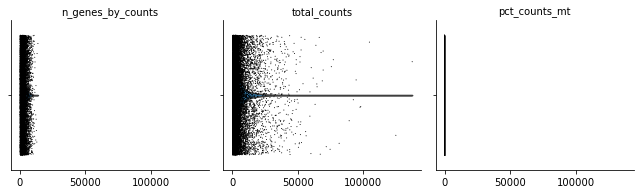

In [81]:
scanpy.pl.violin(encode_genefull, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

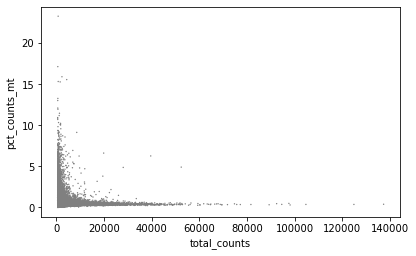

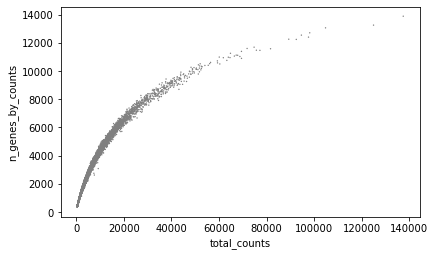

In [82]:
scanpy.pl.scatter(encode_genefull, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(encode_genefull, x='total_counts', y='n_genes_by_counts')

In [83]:
tenx_genefull_filtered = tenx_genefull[tenx_genefull.obs.n_genes_by_counts < 2000, :]
tenx_genefull_filtered = tenx_genefull_filtered[tenx_genefull_filtered.obs.pct_counts_mt < 2.5, :]
tenx_genefull_filtered

View of AnnData object with n_obs × n_vars = 8163 × 29057
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


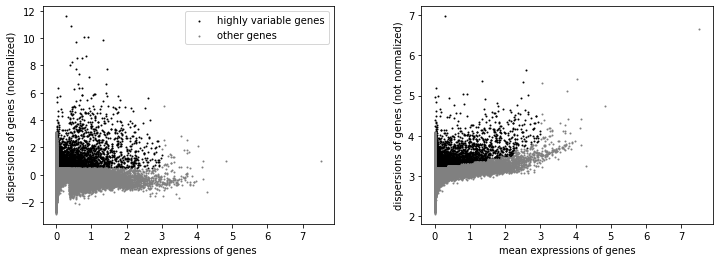

View of AnnData object with n_obs × n_vars = 8163 × 5823
    obs: 'counts', 'ngenes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [84]:
scanpy.pp.normalize_total(tenx_genefull_filtered, target_sum=30000)
scanpy.pp.log1p(tenx_genefull_filtered)
scanpy.pp.highly_variable_genes(tenx_genefull_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(tenx_genefull_filtered)
tenx_genefull_filtered.raw = tenx_genefull_filtered
tenx_genefull_filtered = tenx_genefull_filtered[:, tenx_genefull_filtered.var.highly_variable]
tenx_genefull_filtered

/usr/lib/python3/dist-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'gene_name' as categorical


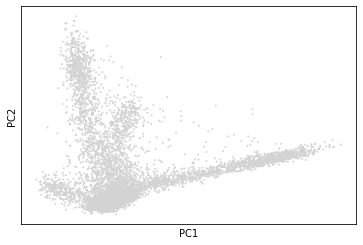

In [85]:
scanpy.pp.regress_out(tenx_genefull_filtered, ['total_counts', 'pct_counts_mt'])
scanpy.pp.scale(tenx_genefull_filtered, max_value=10)
scanpy.tl.pca(tenx_genefull_filtered, svd_solver='arpack')
scanpy.pl.pca(tenx_genefull_filtered)

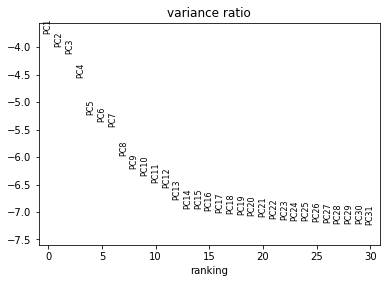

In [86]:
scanpy.pl.pca_variance_ratio(tenx_genefull_filtered, log=True)

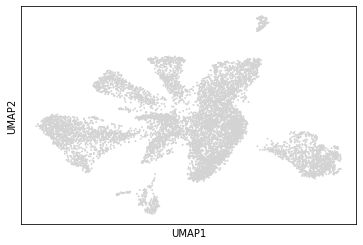

In [87]:
scanpy.pp.neighbors(tenx_genefull_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(tenx_genefull_filtered)
scanpy.pl.umap(tenx_genefull_filtered)

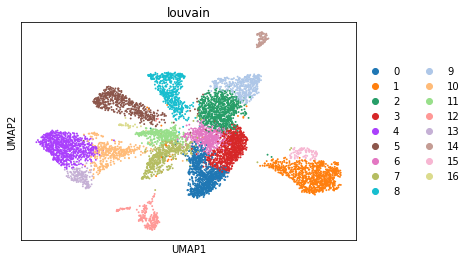

In [88]:
scanpy.tl.louvain(tenx_genefull_filtered)
scanpy.pl.umap(tenx_genefull_filtered, color=['louvain'])

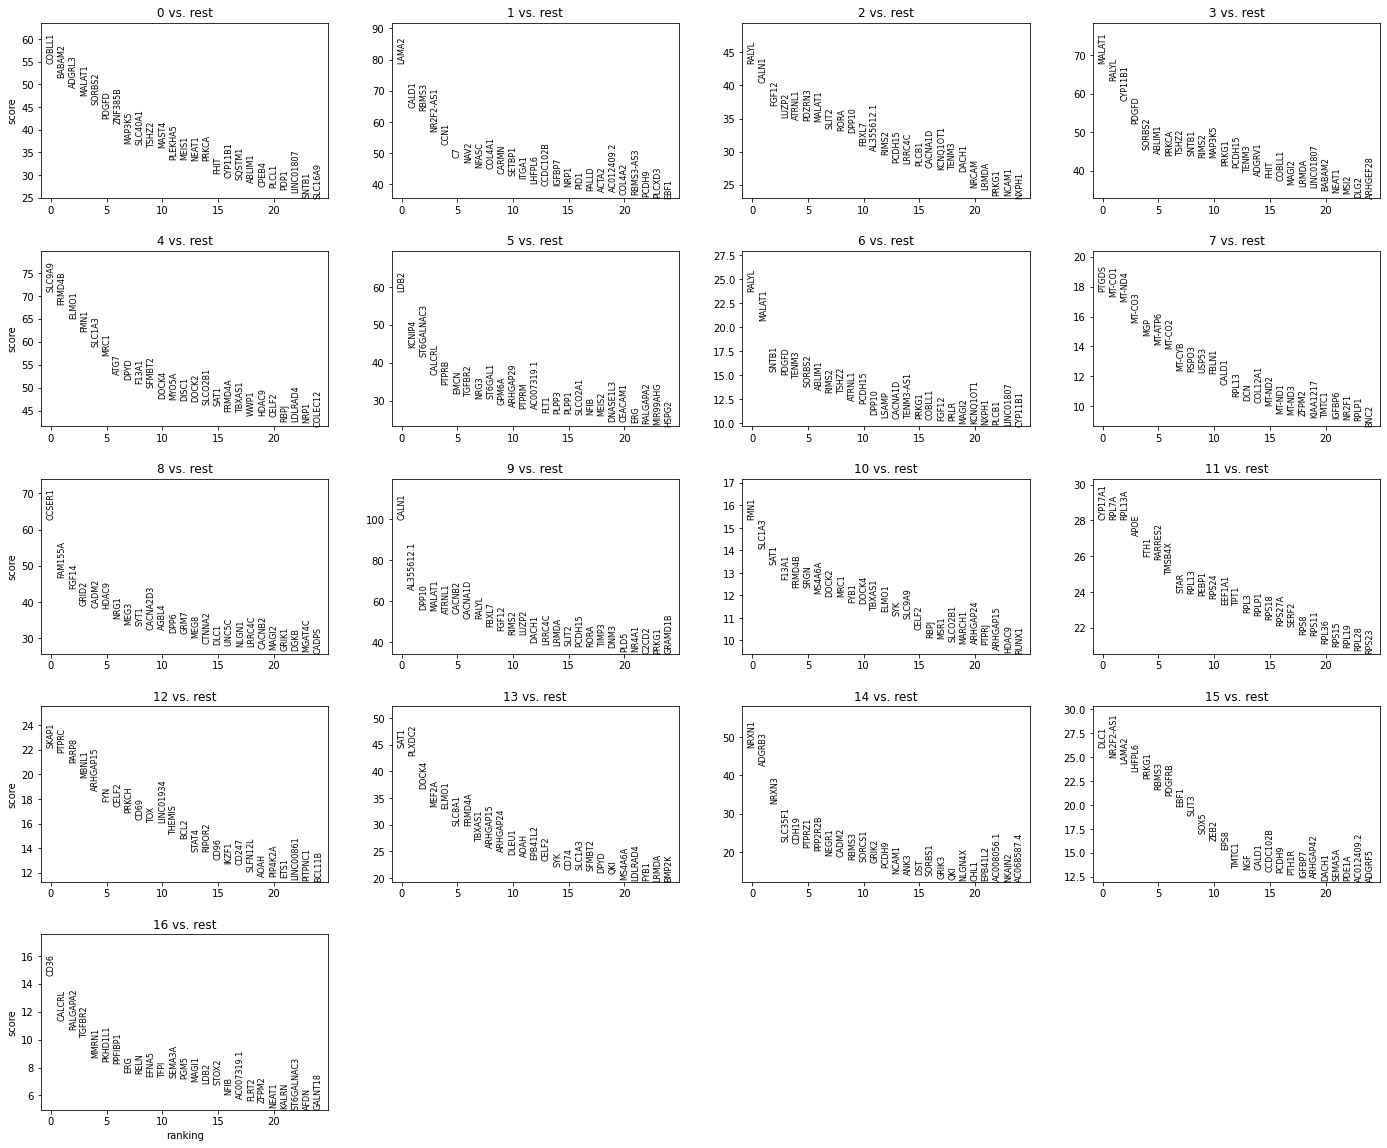

In [89]:
scanpy.tl.rank_genes_groups(tenx_genefull_filtered, 'louvain', method='t-test')
scanpy.pl.rank_genes_groups(tenx_genefull_filtered, n_genes=25, sharey=False, gene_symbols='gene_name')

In [90]:
tenx_genefull_filtered_top_gene_ids = pandas.DataFrame(tenx_genefull_filtered.uns['rank_genes_groups']['names'])
tenx_genefull_filtered_top_gene_names = tenx_genefull_filtered_top_gene_ids.applymap(lambda x: gene_base_to_name.get(x, x))
tenx_genefull_filtered_top_gene_names.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,COBLL1,LAMA2,RALYL,MALAT1,SLC9A9,LDB2,RALYL,PTGDS,CCSER1,CALN1,FMN1,CYP17A1,SKAP1,SAT1,NRXN1,DLC1,CD36
1,BABAM2,CALD1,CALN1,RALYL,FRMD4B,KCNIP4,MALAT1,MT-CO1,FAM155A,AL355612.1,SLC1A3,RPL7A,PTPRC,PLXDC2,ADGRB3,NR2F2-AS1,CALCRL
2,ADGRL3,RBMS3,FGF12,CYP11B1,ELMO1,ST6GALNAC3,SNTB1,MT-ND4,FGF14,DPP10,SAT1,RPL13A,PARP8,DOCK4,NRXN3,LAMA2,RALGAPA2
3,MALAT1,NR2F2-AS1,LUZP2,PDGFD,FMN1,CALCRL,PDGFD,MT-CO3,GRID2,MALAT1,F13A1,APOE,MBNL1,MEF2A,SLC35F1,LHFPL6,TGFBR2
4,SORBS2,CCN1,ATRNL1,SORBS2,SLC1A3,PTPRB,TENM3,MGP,CADM2,ATRNL1,FRMD4B,FTH1,ARHGAP15,ELMO1,CDH19,PRKG1,MMRN1


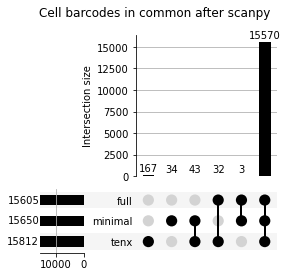

In [91]:
tutoral_barcode_set = upsetplot.from_contents({
    'tenx filtered': tenx_genefull_filtered.obs_names,
    'full filtered': encode_genefull_filtered.obs_names,
    'minimal filtered': minimal_genefull_filtered.obs_names,
})
f = pyplot.figure()
f.suptitle("Cell barcodes in common after scanpy")
_ = upsetplot.plot(common_barcode_set, show_counts=True, fig=f)


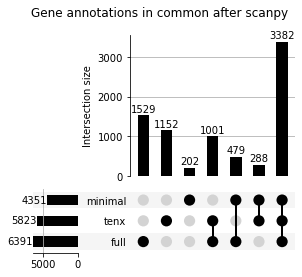

In [96]:
tenx_filtered_base_ids = set(tenx_genefull_filtered.var_names)
full_filtered_base_ids = set()
for x in encode_genefull_filtered.var_names:
    full_filtered_base_ids.add(x.split('.')[0])

minimal_filtered_base_ids = set()
for x in minimal_genefull_filtered.var_names:
    minimal_filtered_base_ids.add(x.split('.')[0])

# tenx is using gencode.v32.primary_assembly.annotation.gtf.filtered
common_filtered_gene_base_set = upsetplot.from_contents({
    'tenx': tenx_filtered_base_ids,
    'full': full_filtered_base_ids,
    'minimal': minimal_filtered_base_ids,
})
f = pyplot.figure()
f.suptitle("Gene annotations in common after scanpy")
_ = upsetplot.plot(common_filtered_gene_base_set, show_counts=True, fig=f)

In [93]:
len(tenx_filtered_base_ids)

5823

In [94]:
len(minimal_filtered_base_ids)

4351

In [95]:
len(tenx_filtered_base_ids.intersection(minimal_base_ids))

4668

In [138]:
def build_confusion_matrix(left, right, N=20):

    confusion = {}
    for cluster in left:
        for gene in left[cluster].head(N):
            confusion.setdefault(gene, {})['left'] = int(cluster)

    for cluster in right:
        for gene in right[cluster].head(N):
            confusion.setdefault(gene, {})['right'] = int(cluster)

    last_left = int(left.columns[-1]) + 1
    last_right = int(right.columns[-1]) + 1

    confusion_matrix = numpy.zeros((last_left+1, last_right+1))

    for gene in confusion:
        x = confusion[gene].get('left', last_left)
        y = confusion[gene].get('right', last_right)
        confusion_matrix[x,y] += 1
    return confusion_matrix

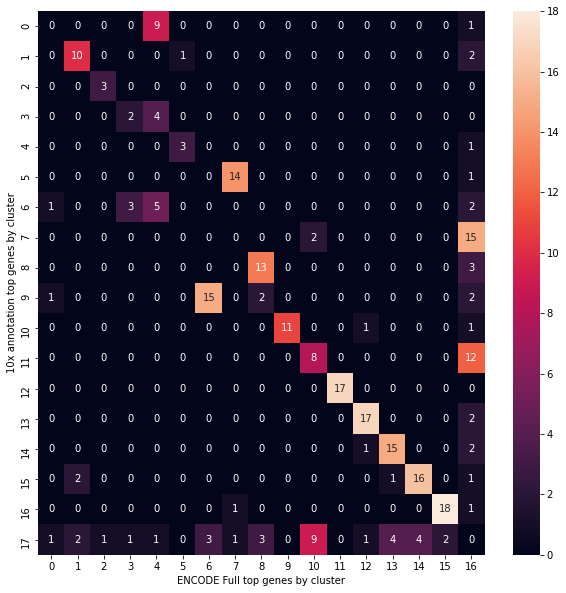

In [139]:
f = pyplot.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
cm = build_confusion_matrix(tenx_genefull_filtered_top_gene_names, encode_genefull_filtered_top_gene_names)
_ = seaborn.heatmap(cm, annot=True, ax=ax)
_ = ax.set_xlabel("ENCODE Full top genes by cluster")
_ = ax.set_ylabel("10x annotation top genes by cluster")


In [ ]:
f = pyplot.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
cm = build_confusion_matrix(tenx_genefull_filtered_top_gene_names, minimal_genefull_filtered_top_gene_names, 10)
_ = seaborn.heatmap(cm, annot=True, ax=ax)
_ = ax.set_xlabel("ENCODE minimal top genes by cluster")
_ = ax.set_ylabel("10x annotation top genes by cluster")

In [ ]:
f = pyplot.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
cm = build_confusion_matrix(encode_genefull_filtered_top_gene_names, minimal_genefull_filtered_top_gene_names)
_ = seaborn.heatmap(cm, annot=True, ax=ax)
_ = ax.set_xlabel("ENCODE minimal top genes by cluster")
_ = ax.set_ylabel("ENCODE full top genes by cluster")